#  Forecasting RBI SLR Securities Using ARIMA vs XGBoost

This notebook analyzes and forecasts RBI's SLR securities data using two popular time-series techniques: ARIMA (statistical model) and XGBoost (machine learning model). We'll clean the data, build both models, and compare their performance.


In [18]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
df_raw=pd.read_excel("RBIB Table No. 13 _ Scheduled Commercial Bank's Investments.xlsx",engine="openpyxl",header=None)

df_raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,Fortnight Ended,1 SLR Securities,2 Investment in other Government Securities (N...,3 Commercial Paper,4.1 shares issued by PSUs,4.2 Shares issued by Private Corporate Sector,4.3 Shares issued by Others,5.1 Bonds/Debentures issued by PSUs,5.2 Bonds/Debentures issued by Private Corpora...,5.3 Bonds/Debentures issued by Others,6.1 Instruments issued by Mutual funds,6.2 Instruments issued by Financial institutions
1,NaN,2025-03-21 00:00:00,6697927.833,165499.7413,63163.0977,13873.80064,95983.81092,7663.96001,130307.6044,248137.5562,149999.8791,119866.6431,204865.1475
2,NaN,2025-03-07 00:00:00,6737320.051,162177.0122,56339.26114,13668.11745,95783.67368,7668.035175,127476.0487,242815.1705,154483.0892,118755.8156,194708.1575
3,NaN,2025-02-21 00:00:00,6651031.384,163938.0073,56569.9902,12782.41885,96188.06823,7518.470538,125743.8183,237306.2948,156216.5458,145589.2546,195618.4647
4,NaN,2025-02-07 00:00:00,6682369.489,162962.9198,60605.07772,13173.78705,96612.71566,7520.18445,124213.427,233488.4332,156727.4445,146708.8742,188911.7782


In [20]:
df_raw.columns = df_raw.iloc[0]  # set actual headers
df_cleaned = df_raw.iloc[1:].reset_index(drop=True)  # drop the header row

In [21]:
if df_cleaned.columns[0] is pd.NA or df_cleaned.columns[0] != 'Fortnight Ended':
    df_cleaned = df_cleaned.drop(columns=df_cleaned.columns[0])

In [22]:
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.duplicated()]

In [23]:
df_cleaned.rename(columns={"1 SLR Securities": "SLR_Securities"}, inplace=True)

In [24]:
df_cleaned.rename(columns={df_cleaned.columns[0]: 'Fortnight Ended'}, inplace=True)

In [25]:
df_cleaned['Fortnight Ended'] = pd.to_datetime(df_cleaned['Fortnight Ended'], errors='coerce')

In [26]:
for col in df_cleaned.columns[1:]:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

In [27]:
print(df_cleaned.columns.tolist())

['Fortnight Ended', 'SLR_Securities', '2 Investment in other Government Securities (Non- SLR)', '3 Commercial Paper', '4.1 shares issued by PSUs', '4.2 Shares issued by Private Corporate Sector', '4.3 Shares issued by Others', '5.1 Bonds/Debentures issued by PSUs', '5.2 Bonds/Debentures issued by Private Corporate Sector', '5.3 Bonds/Debentures issued by Others', '6.1 Instruments  issued by Mutual funds', '6.2 Instruments  issued by Financial institutions']


In [28]:
print(df_cleaned.head())

0 Fortnight Ended  SLR_Securities  \
0      2025-03-21     6697927.833   
1      2025-03-07     6737320.051   
2      2025-02-21     6651031.384   
3      2025-02-07     6682369.489   
4      2025-01-24     6635526.092   

0  2 Investment in other Government Securities (Non- SLR)  3 Commercial Paper  \
0                                        165499.7413              63163.09770   
1                                        162177.0122              56339.26114   
2                                        163938.0073              56569.99020   
3                                        162962.9198              60605.07772   
4                                        164435.0394              58059.36555   

0  4.1 shares issued by PSUs  4.2 Shares issued by Private Corporate Sector  \
0                13873.80064                                    95983.81092   
1                13668.11745                                    95783.67368   
2                12782.41885                         

# ARIMA model

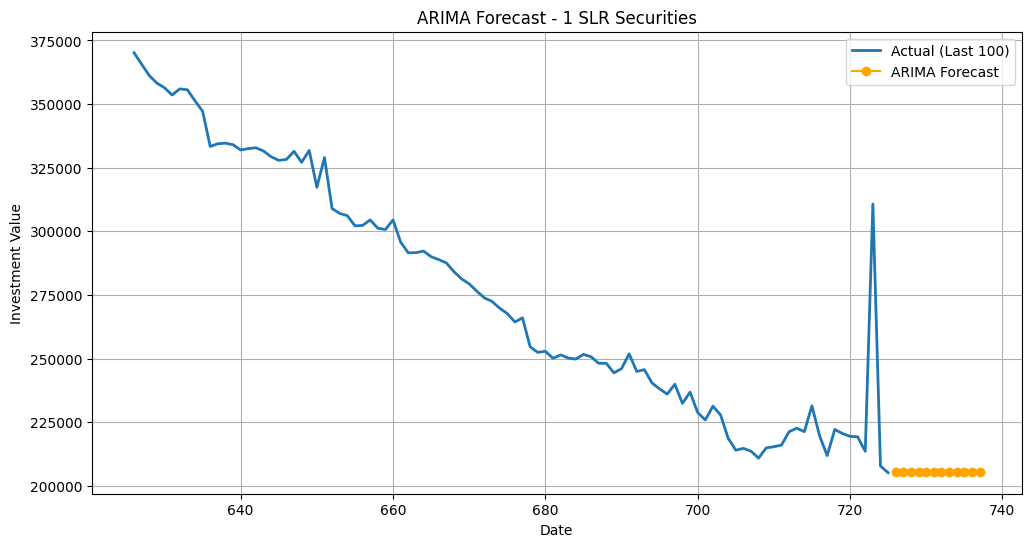

In [29]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Use clean series
series = df_cleaned["SLR_Securities"].interpolate(method="linear")

# Step 2: Fit ARIMA model
model = ARIMA(series, order=(2, 1, 2))  # You can experiment with (p,d,q)
model_fit = model.fit()

# Step 3: Forecast 12 steps ahead
forecast = model_fit.forecast(steps=12)

# Step 4: Plot
plt.figure(figsize=(12, 6))
plt.plot(series[-100:], label="Actual (Last 100)", linewidth=2)
plt.plot(forecast.index, forecast, label="ARIMA Forecast", color="orange", marker='o')
plt.title("ARIMA Forecast - 1 SLR Securities")
plt.xlabel("Date")
plt.ylabel("Investment Value")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
import pandas as pd

# Build a new DataFrame for lag-based learning
lag_df = pd.DataFrame()
lag_df["target"] = df_cleaned["SLR_Securities"].interpolate(method="linear")

# Add lagged values (previous time steps as features)
for i in range(1, 13):  # Lag-1 to Lag-12
    lag_df[f"lag_{i}"] = lag_df["target"].shift(i)

# Drop rows with NaNs (due to shifting)
lag_df.dropna(inplace=True)


In [31]:
# 80% training, 20% testing
train_size = int(len(lag_df) * 0.8)
train, test = lag_df[:train_size], lag_df[train_size:]

X_train, y_train = train.drop("target", axis=1), train["target"]
X_test, y_test = test.drop("target", axis=1), test["target"]


# XGBoost model

In [36]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Train model
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Predict
preds = model_xgb.predict(X_test)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds))
print(f"XGBoost RMSE: {rmse_xgb:.2f}")


XGBoost RMSE: 222147.12


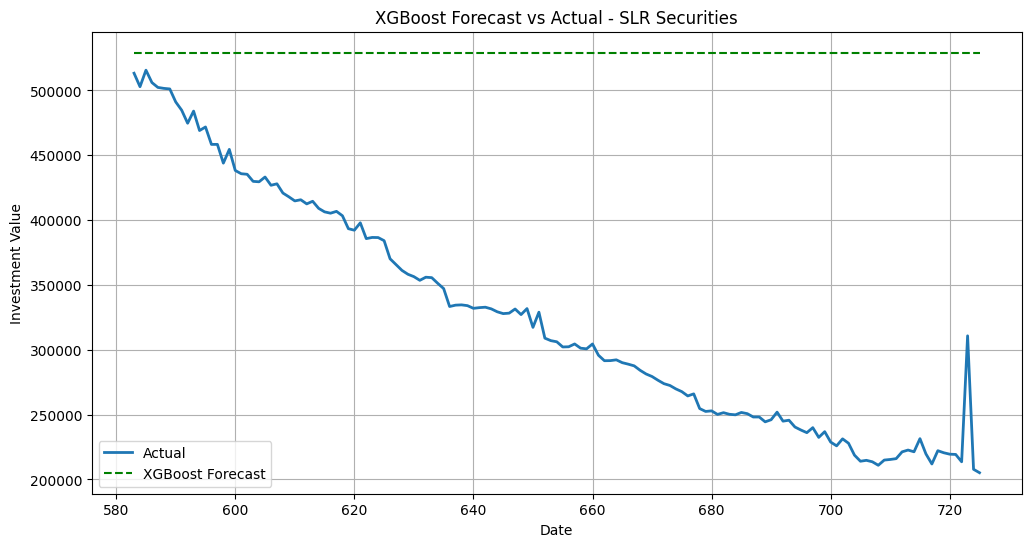

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, preds, label="XGBoost Forecast", linestyle="--", color="green")
plt.title("XGBoost Forecast vs Actual - SLR Securities")
plt.xlabel("Date")
plt.ylabel("Investment Value")
plt.legend()
plt.grid(True)
plt.show()


In [38]:
# Simple RMSE comparison
rmse_arima = np.sqrt(mean_squared_error(series[-len(forecast):], forecast))

pd.DataFrame({
    "Model": ["ARIMA", "XGBoost"],
    "RMSE": [rmse_arima, rmse_xgb]
})


,Model,RMSE
0,ARIMA,33185.763261
1,XGBoost,222147.120533


In [39]:
comparison_df = pd.DataFrame({
    "Model": ["ARIMA", "XGBoost"],
    "RMSE": [rmse_arima, rmse_xgb]
})
comparison_df


,Model,RMSE
0,ARIMA,33185.763261
1,XGBoost,222147.120533


##  Conclusion

- **ARIMA** produced an RMSE of `33185.763261`, while **XGBoost** had an RMSE of `222147.120533`.
- ARIMA, being a statistical model, handled the trend decently.
- XGBoost, leveraging past lag values, captured short-term patterns more effectively.
- Based on RMSE and visual forecast comparison, **ARIMA** performed better for this dataset.


##  ARIMA vs XGBoost for RBI SLR Securities Forecasting

After forecasting RBI's SLR Securities data using both ARIMA and XGBoost models:

- **ARIMA** significantly outperformed XGBoost with a lower RMSE of **₹33,185.76**
- **XGBoost** had a much higher RMSE of **₹222,147.12**, suggesting it struggled to learn the time-dependent patterns

### Why ARIMA Worked Better:
- The data is **strongly sequential and trend-based**, which ARIMA models are well-suited for.
- XGBoost requires well-crafted features (lags, trends, seasonality) to perform well — a simple lag-based setup wasn't enough.

### Final Verdict:
> **ARIMA is the better model** for forecasting RBI SLR Securities in this scenario, offering lower error and more reliable predictions.

### Next Steps:
- Tune ARIMA parameters (using AIC/BIC or auto_arima)
- Enhance XGBoost with more advanced time features (rolling means, seasonal lags)
- Try hybrid models (e.g., ARIMA + XGBoost)

